In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle


In [16]:
# Load dataset
X_train_scaled = pd.read_csv('data/X_train_scaled.csv')
X_test_scaled = pd.read_csv('data/X_test_scaled.csv')
y_train = pd.read_csv('data/y_train.csv').values.ravel()  # Convert to 1D array
y_test = pd.read_csv('data/y_test.csv').values.ravel() 

In [17]:
# Set random seed
np.random.seed(42)

In [18]:
# Define base estimators (level 0)
base_estimators = [
    ('random_forest', RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )),
    ('gradient_boosting', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        random_state=42
    ))
]

In [19]:
# Create meta-model
meta_model = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    solver='lbfgs'
)

# Create Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba',  # Use probability predictions
    n_jobs=-1
)


Training Stacking Classifier with tuned hyperparameters...
Training completed in 41.93 seconds (0.70 minutes)

=== Stacking Model Results ===
Accuracy: 0.8120 (81.20%)
Training Time: 41.93 seconds

Confusion Matrix Values:
True Negatives (Confirmed correctly predicted): 572
False Positives (Confirmed predicted as Candidate): 111
False Negatives (Candidate predicted as Confirmed): 145
True Positives (Candidates correctly predicted): 534

Detailed Classification Report:
              precision    recall  f1-score   support

   CONFIRMED       0.80      0.84      0.82       683
   CANDIDATE       0.83      0.79      0.81       679

    accuracy                           0.81      1362
   macro avg       0.81      0.81      0.81      1362
weighted avg       0.81      0.81      0.81      1362



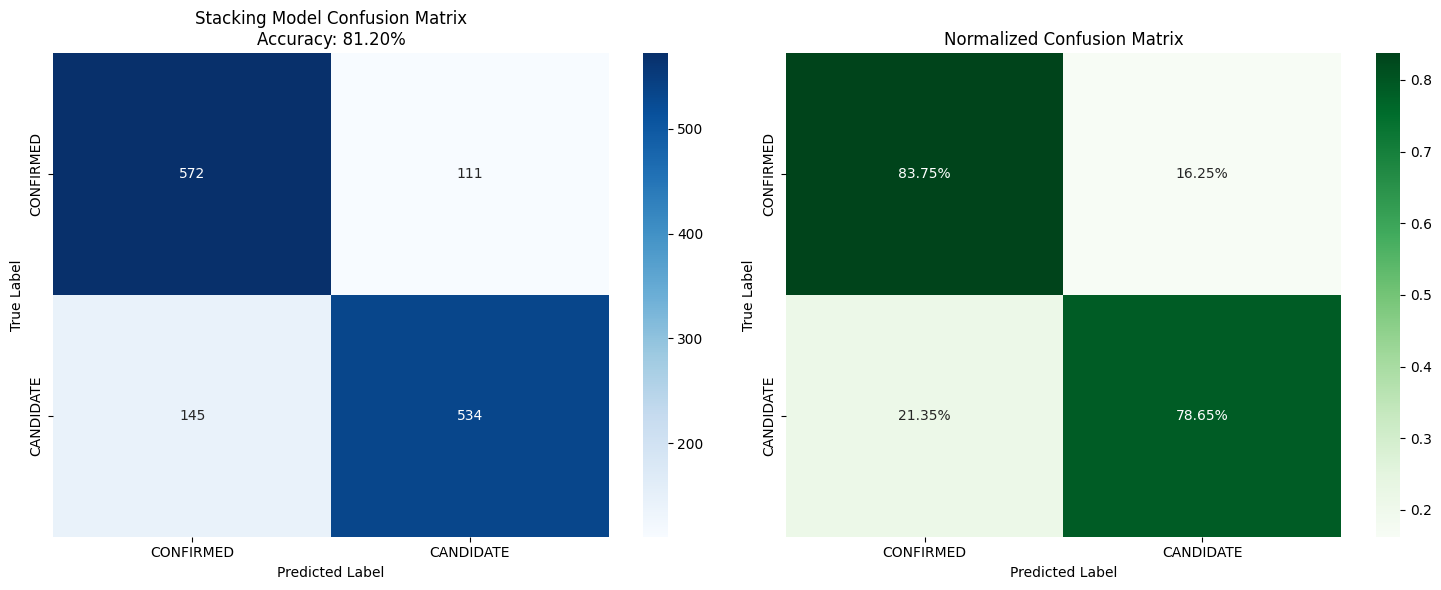

In [20]:
# Train the model
print("Training Stacking Classifier with tuned hyperparameters...")
start_time = time.time()

stacking_model.fit(X_train_scaled, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Make predictions
y_pred = stacking_model.predict(X_test_scaled)
y_pred_proba = stacking_model.predict_proba(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Stacking Model Results ===")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Training Time: {training_time:.2f} seconds")

tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix Values:")
print(f"True Negatives (Confirmed correctly predicted): {tn}")
print(f"False Positives (Confirmed predicted as Candidate): {fp}")
print(f"False Negatives (Candidate predicted as Confirmed): {fn}")
print(f"True Positives (Candidates correctly predicted): {tp}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['CONFIRMED', 'CANDIDATE']))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['CONFIRMED', 'CANDIDATE'],
            yticklabels=['CONFIRMED', 'CANDIDATE'])
axes[0].set_title(f'Stacking Model Confusion Matrix\nAccuracy: {accuracy*100:.2f}%')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['CONFIRMED', 'CANDIDATE'],
            yticklabels=['CONFIRMED', 'CANDIDATE'])
axes[1].set_title('Normalized Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('stacking_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save the model
with open('models/stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

print("Model saved successfully!")